## This notebook is for plotting CVs of trajectories and visualization with chemiscope

In [2]:
import chemiscope
import torch 
import numpy as np
import os
from typing import Dict, List, Optional
from scipy.stats import moment
from metatensor.torch import Labels, TensorBlock, TensorMap
from metatomic.torch import (
    AtomisticModel,
    ModelCapabilities,
    ModelEvaluationOptions,
    ModelMetadata,
    ModelOutput,
    System,
    systems_to_torch,
    load_atomistic_model
)
from featomic.torch import SoapPowerSpectrum
import vesin
from ase.io import read
import matplotlib.pyplot as plt

In [3]:
cwd = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/metad/test'
model_name = 'soap_wrapper_zmin25.0_zmax35.0.pt'
model_name = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/results/amorph-metad-1ps/v0/SOAP/866/all/PCAfull/interval_1/lag_0/sigma_0/ridge_a1e-05/SOAP_866_[8]/model_soap.pt'
trj_name = 'positions.lammpstrj'

In [4]:
# Load model
CVmodel = load_atomistic_model(os.path.join(cwd, model_name), extensions_directory='.')


[W209 16:28:29.174715000 model.cpp:959] Warning: Current torch version (2.8.0) is not compatible with the version (2.7.1) used to export the model at '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/results/amorph-metad-1ps/v0/SOAP/866/all/PCAfull/interval_1/lag_0/sigma_0/ridge_a1e-05/SOAP_866_[8]/model_soap.pt'; proceed at your own risk. (function check_atomistic_model)


RuntimeError: 

__init__(__torch__.torch.classes.metatomic.ModelOutput _0, str quantity="", str unit="", bool per_atom=False, str[] explicit_gradients=[]) -> NoneType _0:
Expected at most 5 arguments but found 6 positional arguments.
:
  File "code/__torch__/metatomic/torch/model.py", line 104
        _43 = (options).outputs_getter()
        _44 = __torch__.torch.classes.metatomic.ModelOutput.__new__(__torch__.torch.classes.metatomic.ModelOutput)
        _45 = (_44).__init__("", "", False, annotate(List[str], []), "", )
               ~~~~~~~~~~~~~ <--- HERE
        requested = torch.get(_43, name, _44)
        _46 = torch.eq((declared).quantity_getter(), "")


#### Load trajectory for testing

In [29]:
structures = read('/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/metad/positions.lammpstrj', index=':')
structures = structures[::10]

# Adjust trj:

In [30]:
systems = systems_to_torch(structures, dtype=torch.float64)

systems_new = []
for i, system in enumerate(systems):
    
    #atoms = structures[i]
    nlistoptions = CVmodel.requested_neighbor_lists()[0]
    print(nlistoptions)
    nlist = vesin.NeighborList(cutoff=nlistoptions.cutoff, full_list=nlistoptions.full_list) 
    i, j, S, D = nlist.compute(
        points=system.positions,
        box=system.cell, 
        periodic=True,
        quantities="ijSD"
    )
    #i, j, S, D = ase_neighbor_list(quantities="ijSD", a=atoms, cutoff=4.5)
    i = torch.from_numpy(i.astype(int))
    j = torch.from_numpy(j.astype(int))
    neighbor_indices = torch.stack([i, j], dim=1)
    neighbor_shifts = torch.from_numpy(S.astype(int))

    sample_values = torch.hstack([neighbor_indices, neighbor_shifts])
    samples = Labels(
        names=[
            "first_atom",
            "second_atom",
            "cell_shift_a",
            "cell_shift_b",
            "cell_shift_c",
        ],
        values=sample_values,
    )

    neighbors = TensorBlock(
        values=torch.from_numpy(D).reshape(-1, 3, 1),
        samples=samples,
        components=[Labels.range("xyz", 3)],
        properties=Labels.range("distance", 1),
    )
    system.add_neighbor_list(nlistoptions, neighbors)
    systems_new.append(system)
systems = systems_new

NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=F

#### Get CV values

In [31]:
selected_atoms = Labels(
        names=["system", "atom"],
        values=torch.tensor([[0, j] for j in np.arange(0, len(structures[0]), 3)], dtype=torch.int32),)
    

eval_options = ModelEvaluationOptions(
            length_unit='',
            outputs={"features": ModelOutput(per_atom=False), 
                     "features/per_atom": ModelOutput(per_atom=True)},
            selected_atoms=selected_atoms,
        )
CVs = []
CVs_per_atom = []
for system in systems:
    cv = CVmodel(
        systems=[system],
        options=eval_options,
        check_consistency=True,
    )
    CVs.append(cv['features'].block().values)
    CVs_per_atom.append(cv['features/per_atom'].block().values)

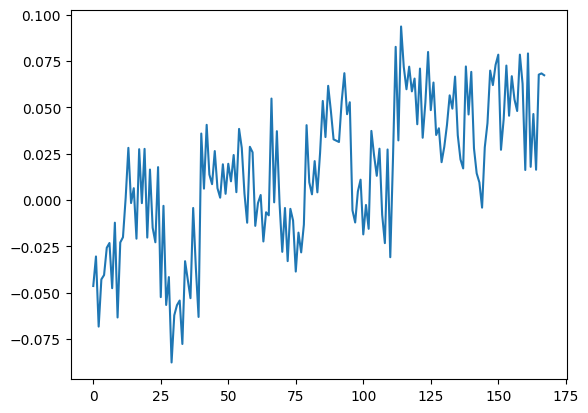

In [32]:
CVperatom = torch.stack(CVs_per_atom, dim=0).squeeze().numpy()
CV = torch.stack(CVs, dim=0).squeeze().numpy()
plt.plot(CV)



In [33]:
io = structures[0].get_atomic_numbers() == 8
ins = [np.where(np.isin(frame.symbols, ["O"]))[0] for frame in structures] #O indices

time=[]
#for atoms in traj:
#    time.append(atoms.info['timestep'])
time = np.arange(0, len(structures))*1.0  # 1ps interval

envs = []
for j in range(len(structures)):
    for i in ins[0]:
        envs.append((j, i, 3.5))

cs = chemiscope.show(
    structures, 
    properties={
        'time': time,
        'o_cv': {"values": np.hstack(CVperatom), "target": "atom"},
        'cv': {"values": CV, "target": "structure"},},
    mode="structure",
    settings=chemiscope.quick_settings(trajectory=True, structure_settings={"unitCell":True,
             'environments': {'activated': True}, 'map': {'color': {'property': 'o_cv'}}, 'color': {'property': 'o_cv', 'min': -0.1,
                              'max': 0.1, 'transform': 'linear','palette': 'bwr'} }),
    environments=envs, #[(j,i,3.5) for j in range(len(structures)) for i in io]
)


properties = {
        'time': time,
        'cv_peratom': {"values": np.hstack(CVperatom), "target": "atom"},
        'cv': {"values": CV, "target": "structure"},
}

settings = chemiscope.quick_settings(trajectory=True, structure_settings={
    "unitCell":True,
    'environments': {'activated': True}, 
    'map': {'color': {'property': 'cv_peratom'}}, 
    'color': {'property': 'cv_peratom', 
              'min': -0.1, 
              'max': 0.1, 
              'transform': 'linear',
              'palette': 'bwr',
        } 
    }
)

chemiscope.write_input(
    path="trajectory-waterice-CV.json.gz",
    # dataset metadata can also be included to provide a self-contained description
    # of the data, authors, and references
    metadata={
        "name": "SOAP CV trj",
        "description": (
            "CV per atom for a water-ice trajectory"
        ),
        "authors": ["Markus Fasching, Hannah Tuerk"],
    },
    structures=structures,
    properties=properties,
    environments=envs,
    settings=settings,
)

In [5]:
chemiscope.show_input("trajectory-waterice-CV.json.gz")
    

<ChemiscopeWidget(meta={'name': 'SOAP CV trj', 'description': 'CV per atom for a water-...}, settings={'map': …

In [1]:
ins = [np.where(np.isin(frame.symbols, ["O"]))[0] for frame in structures] #O indices

values = CVperatom

values = [i for val in values for i in val]
print(np.max(values))
envs = []
for j in range(len(structures)):
    for i in ins[j]:
        envs.append((j, i, 3.5))

cs2 = chemiscope.show(
    structures, 
    properties={
        'time': time,
        "cv_peratom": {"values": values, "target": "atom"},
        'cv': {"values": CV, "target": "structure"},
    },
    #mode="structure",
    settings=chemiscope.quick_settings(trajectory=True, structure_settings={"unitCell":True,
             'environments': {'activated': False}, 'color': {'property': 'cv_peratom', 'min': -1,
                              'max': 1, 'transform': 'linear','palette': 'bwr'} }),
    environments=envs,
)
#cs2

NameError: name 'structures' is not defined

In [55]:
cs2

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'joinPoints': True}, 'structure': [{'keepOrientation':…